In [8]:
# import nltk

In [9]:
# nltk.download()

In [1]:
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]

In [2]:
messages[0]

'ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [3]:
import pandas as pd

In [4]:
messages = pd.read_csv("smsspamcollection/SMSSpamCollection",sep="\t",names=['label','text'])

In [5]:
messages.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
messages.groupby("label").describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

In [7]:
messages['text_length'] = messages['text'].apply(len)

In [8]:
messages.head()

,label,text,text_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
%matplotlib inline

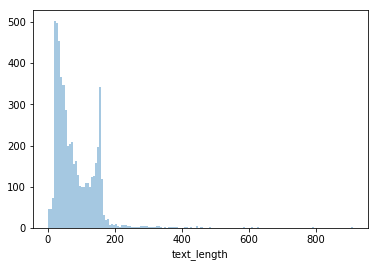

In [11]:
sns.distplot(messages['text_length'],bins=150,kde=False)

In [12]:
messages['text_length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: text_length, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a192b8a58>,
      dtype=object)

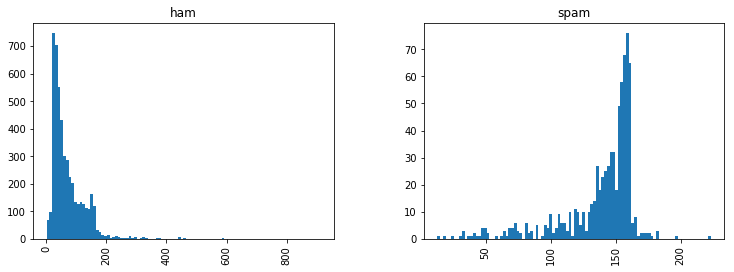

In [13]:
messages.hist(column='text_length',by='label',figsize = (12,4),bins=100)

## TEXT PRE-PROCESSING

Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.


In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.

Let's create a function that will process the string in the message column, then we can just use **apply()** in pandas do process all the text in the DataFrame.

First removing punctuation. We can just take advantage of Python's built-in **string** library to get a quick list of all the possible punctuation:

In [14]:
from nltk.corpus import stopwords

In [15]:
import string

In [16]:
stopwords.words('english')[0:10]
#showing some common english words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

Let's see an example output on on column:

**Note:**
We may get some warnings or errors for symbols we didn't account for or that weren't in Unicode (like a British pound symbol)

In [17]:
#Make function convert text in messages to 
def text_processing(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    nopunc = [word for word in text if word not in string.punctuation]
    
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [18]:
#Check to make sure its working
messages['text'].head().apply(text_processing)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: text, dtype: object

### Continuing Normalization

There are a lot of ways to continue normalizing this text. Such as [Stemming](https://en.wikipedia.org/wiki/Stemming) or distinguishing by [part of speech](http://www.nltk.org/book/ch05.html).

NLTK has lots of built-in tools and great documentation on a lot of these methods. Sometimes they don't work well for text-messages due to the way a lot of people tend to use abbreviations or shorthand, For example:
    
    'Nah dawg, IDK! Wut time u headin to da club?'
    
versus

    'No dog, I don't know! What time are you heading to the club?'
    
Some text normalization methods will have trouble with this type of shorthand and so I'll leave you to explore those more advanced methods through the [NLTK book online](http://www.nltk.org/book/).

For now we will just focus on using what we have to convert our list of words to an actual vector that SciKit-Learn can use.

## Vectorization

Currently, we have the messages as lists of tokens (also known as [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

Each vector will have as many dimensions as there are unique words in the SMS corpus.  We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message. 

For example:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
bow_transformer = CountVectorizer(analyzer=text_processing).fit(messages['text'])
#SImilar to fit, transform of scalar
#bow_transformer = CountVectorizer(analyzer=text_processing)
#bow_transformer.fit(messages['text'])
#then transform

In [21]:
print(len(bow_transformer.vocabulary_))

11425


In [23]:
#fit and transform of CountVectorize object gives above matrix with words as index and message text as columns
message_bow = bow_transformer.transform(messages['text'])

In [24]:
print("Shape of Sparse Matrix",message_bow.shape)
print("Amount of non zero occurence",message_bow.nnz)

Shape of Sparse Matrix (5572, 11425)
Amount of non zero occurence 50548


In [28]:
#Sparcity
sparsity = (100 * message_bow.nnz) / (message_bow.shape[0] * message_bow.shape[1])
print("Sparcity :",sparsity)

Sparcity : 0.07940295412668218


After the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.

In [29]:
from sklearn.feature_extraction.text import TfidfTransformer

In [30]:
tfid_transformer = TfidfTransformer()

In [31]:
tfid_transformer.fit(message_bow)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [32]:
message_tfid = tfid_transformer.transform(message_bow)

In [33]:
message_tfid

<5572x11425 sparse matrix of type '<class 'numpy.float64'>'
	with 50548 stored elements in Compressed Sparse Row format>

There are many ways the data can be preprocessed and vectorized. These steps involve feature engineering and building a "pipeline". I encourage you to check out SciKit Learn's documentation on dealing with text data as well as the expansive collection of available papers and books on the general topic of NLP.

## Training a Model

With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a [variety of reasons](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), the Naive Bayes classifier algorithm is a good choice.

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

In [34]:
from sklearn.naive_bayes import MultinomialNB

In [35]:
#Model naive_bayes useful for nlp model fit and predict

In [36]:
spam_detect_model = MultinomialNB()

In [37]:
spam_detect_model.fit(message_tfid,messages['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [38]:
spam_detect_predictions = spam_detect_model.predict(message_tfid)

In [39]:
print(spam_detect_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [40]:
from sklearn.metrics import classification_report

In [41]:
print(classification_report(messages['label'],spam_detect_predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

   micro avg       0.98      0.98      0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



## Train Test Split

In [42]:
from sklearn.model_selection import train_test_split

In [57]:
msg_train, msg_test, label_train, label_test = train_test_split(messages['text'],messages['label'],test_size = 0.2)

## CREATE DATA PIPELINE

training and testing data should always be seperate for predictions evaluations
Doing again above steps of CountVectorizer,TfidTransformer and MultinomialNB can be hectic
Use Python pipeline to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

In [59]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [60]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_processing at 0x1a1bb20510>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=N...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [61]:
predictions = pipeline.predict(msg_test)

In [62]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1009
        spam       0.72      1.00      0.83       106

   micro avg       0.96      0.96      0.96      1115
   macro avg       0.86      0.98      0.91      1115
weighted avg       0.97      0.96      0.97      1115

